In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

In [2]:
dir = Path('data/ECG_Image_data/train')

filepaths = list(dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

,Filepath,Label
0,data\ECG_Image_data\train\F\F1.png,F
1,data\ECG_Image_data\train\F\F10.png,F
2,data\ECG_Image_data\train\F\F100.png,F
3,data\ECG_Image_data\train\F\F101.png,F
4,data\ECG_Image_data\train\F\F102.png,F
...,...,...
99194,data\ECG_Image_data\train\V\V995.png,V
99195,data\ECG_Image_data\train\V\V996.png,V
99196,data\ECG_Image_data\train\V\V997.png,V
99197,data\ECG_Image_data\train\V\V998.png,V


In [3]:
dataframe['Label'].value_counts()

N    75709
M     8405
Q     6431
V     5789
S     2223
F      642
Name: Label, dtype: int64

In [5]:
samples = []
for category in ['N','M','Q','V','S','F']:
    category_slice = dataframe.query("Label == @category")
    samples.append(category_slice.sample(640, random_state=1))

dataframe_train = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

N    640
Q    640
S    640
F    640
M    640
V    640
Name: Label, dtype: int64

In [6]:
dataframe_train

,Filepath,Label
0,data\ECG_Image_data\train\N\N80645.png,N
1,data\ECG_Image_data\train\Q\Q644.png,Q
2,data\ECG_Image_data\train\S\S2383.png,S
3,data\ECG_Image_data\train\S\S2269.png,S
4,data\ECG_Image_data\train\F\F138.png,F
...,...,...
3835,data\ECG_Image_data\train\S\S1594.png,S
3836,data\ECG_Image_data\train\M\M5641.png,M
3837,data\ECG_Image_data\train\M\M8804.png,M
3838,data\ECG_Image_data\train\N\N46498.png,N


In [7]:
def gray_torgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.merge((image,image,image))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=gray_torgb,
    rescale=1./255,
    validation_split=0.2
  
)


In [9]:
size=224
color_mode='rgb'
batch_size=32

train_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)


Found 3072 validated image filenames belonging to 6 classes.
Found 768 validated image filenames belonging to 6 classes.


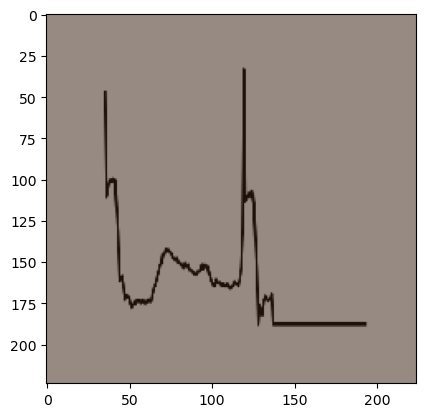

In [11]:
plt.imshow(train_images[0][0][3])

In [12]:

from tensorflow.keras.applications import ResNet50
pretrained_model = ResNet50(
                              input_shape=(224,224,3),
                              include_top= False,
                              weights='imagenet',
                              pooling='avg'
                              )

pretrained_model.trainable = False

94765736/94765736 [==============================] - 6s 0us/step


In [13]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

model = Sequential ([
                        pretrained_model,
                        Flatten(),
                        Dropout(0.2),
                        Dense(128, activation='relu'),
                        Dense(64, activation='relu'),
                        Dense(6, activation='softmax')
                    ])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 23858630 (91.01 MB)
Trainable params: 2709

In [14]:
model.compile(loss='categorical_crossentropy',optimizer='adam',
            metrics=['accuracy',
                     'Precision',
                     'Recall',
                     tf.keras.metrics.AUC(
                                    num_thresholds=200,
                                    curve="ROC",
                                    summation_method="interpolation",
                                    multi_label=False
                                    )])

In [16]:
result=model.fit(
    train_images,
    steps_per_epoch=3072//32,
    validation_data=val_images,
    validation_steps=768//32,
    epochs=10
)
# 50 epochs 

Epoch 1/10
96/96 [==============================] - 120s 1s/step - loss: 1.3298 - accuracy: 0.4255 - precision: 0.6679 - recall: 0.1204 - auc: 0.8157 - val_loss: 0.9028 - val_accuracy: 0.5065 - val_precision: 0.7377 - val_recall: 0.2930 - val_auc: 0.9178
Epoch 2/10
96/96 [==============================] - 127s 1s/step - loss: 0.7716 - accuracy: 0.6927 - precision: 0.7774 - recall: 0.4785 - auc: 0.9445 - val_loss: 0.5631 - val_accuracy: 0.8086 - val_precision: 0.8750 - val_recall: 0.6562 - val_auc: 0.9769
Epoch 3/10
96/96 [==============================] - 146s 2s/step - loss: 0.5606 - accuracy: 0.7920 - precision: 0.8253 - recall: 0.7243 - auc: 0.9709 - val_loss: 0.3889 - val_accuracy: 0.8958 - val_precision: 0.9032 - val_recall: 0.8867 - val_auc: 0.9891
Epoch 4/10
96/96 [==============================] - 167s 2s/step - loss: 0.4221 - accuracy: 0.8604 - precision: 0.8745 - recall: 0.8411 - auc: 0.9839 - val_loss: 0.3245 - val_accuracy: 0.9193 - val_precision: 0.9216 - val_recall: 0.918

In [17]:
model.save("ECG_Model1.h5")

c:\Users\Ashlinder Kaur\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
